# Implicit coupling

## Principles of code-coupling

Here is a brief recap from the first notebook on the basic principles.
Our framework is suited to coupled systems that take the following form :
\begin{equation}
    \begin{cases}
        \dot{x_1} &=  f_1(x_1, u_1, t) \\
        \dot{x_2} &=  f_2(x_2, u_2, t) \\
        ... \\
        \dot{x_N} &=  f_N(x_N, u_N, t) \\
    \end{cases}
\end{equation}
where the inputs $u_i$ have the general form $u_i = g_i(x_1, .., x_N)$.

In the present approach, at every coupling step, each subsystem is integrated independently, with a prediction $\hat{u}_i$ of its input $u_i$:

$$x_{i,n+1} = x_{i,n} + \int_{t}^{t+\Delta t} f_i(x_i(\eta), \hat{u}_{i}(\eta), \eta) d\eta$$

Typically, $\hat{u}_i$ is a polynomial function of time, which is extrapolating the previous values of $u_i$ at times $t_n, t_{n-1},..., t_{n-p}$. It can be shown that, for $p$-th degree polynomial predicitions $\hat{u}_i$, the global error is $O(\Delta t^p)$.

In this notebook, we will see that such an extrapolation may hinder the overall stability of the coupling. A remedy will then be introduced: *implicit coupling*.

## Toy model : dual spring mass
We take the toy model from the previous notebooks, which models the dynamics of two mass-spring systems linked in series. A sketch of the system is given in Figure 1.

<!--- ![sketch](sketch_springmass.png "Figure 1 - Sketch of the system") -->
<img src="sketch_springmass.png" alt="sketch" width="500"/>
Both bodies have equal mass, and both springs have the same stiffness $k$.

The system dynamics are governed by the following equations :
\begin{equation}
    \begin{cases}
        m \ddot{x_1} &=  &k (x_2 - x_1) - k(x_1-0) \\
        m \ddot{x_2} &= -&k (x_2 - x_1) + k(1-x_2)
    \end{cases}
\end{equation}

In the previous notebook, we have implemented a partionned approach, where each mass has its own solver. The following code implements this.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from rhapsopy.coupling import Orchestrator
from rhapsopy.accelerators import NewtonSolver, DampedNewtonSolver, IQNSolver, AitkenUnderrelaxationSolver, AitkenScalarSolver, FixedPointSolver, AndersonSolver, ExplicitSolver

k=10.
m=1.
L0=1.
y0_global = np.array([0.3, 0, 0.8, 0])
tf = 10.

A=np.array(((0.,1,0,0),
            (-2*k/m,0,k/m,0),
            (0,0,0,1),
            (k/m,0,-2*k/m,0)))
def coupled_ode(t,y):
    return A @ y + np.array((0.,0,0,k/m))

# monolithic approach
sol = solve_ivp(fun=coupled_ode,
                y0=y0_global, t_span=[0.,10.],
                method='LSODA', atol=1e-6, rtol=1e-6)

def odefun_single(t,x,inputs):
    # x = [position, speed]
    dxdt = np.zeros((2,))
    dxdt[0] = x[1]
    dxdt[1] = (1/m) * ( k*(inputs['xip1'](t)-x[0]-L0) - k*(x[0]-inputs['xim1'](t)-L0) )
    return dxdt

from rhapsopy.coupling import BaseCoupler
class SpringMassCoupler(BaseCoupler):
    def __init__(self,k,m):
        self.k = k
        self.m = m
        self.nCouplingVars = 2 # we have 2 coupling variables: the positions of both masses
        self.nSubsystems   = 2 # we have 2 coupled subsystems
        
    def getCouplingVars(self,t,y):
        """ Return the coupling variables, which are simply the speed and positions of the nodes """
        return y[::2]

    def integrateSingleSubsystem(self, isolv, t0, y0, dt, preds, rtol=None, bDebug=False):
        """ Performs one iteration of a code coupling step (Jacobi or Gauss-Seidel)
              --> computes the value of the overall state vector at time t+dt,
                  starting from state y at time t. """
        # get each subsystem's state vector
        y0_subsystems = [y0[2*i:2*(i+1)] for i in range(2)]
        
        # Distribute the predictions
        current_input = {}
        if isolv==0: # first mass
            current_input['xim1'] = lambda t: 0. # left attachment point
            current_input['xip1'] = lambda t: preds[1].evaluate(t)
        else: # second mass
            current_input['xim1'] = lambda t: preds[0].evaluate(t)
            current_input['xip1'] = lambda t: 1. # right attachment point

        # perform time integration
        if rtol is None: rtol=1e-6
        atol = rtol
        current_out = solve_ivp(fun=lambda t,y : odefun_single(t, y, inputs=current_input),
                                y0=y0_subsystems[isolv], t_span=[t0,t0+dt],
                                max_step=dt, first_step=dt/2, #TODO: sometimes first_step=dt raises issues in Scipy
                                method='RK45', atol=atol, rtol=rtol)
        if not current_out.success:
            raise Exception(current_out.message)
        return current_out

In the first notebook, the coupled integration result looked good, however we used a lot of coupling steps. What happens if we take fewer steps ? Let us investigate:

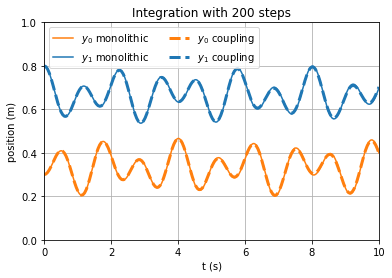

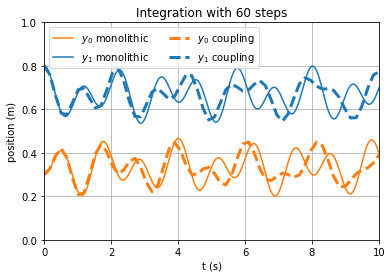

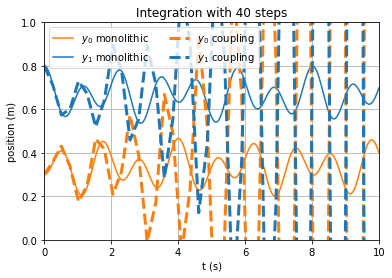

In [2]:
coupler = SpringMassCoupler(k=k,m=m)

conductor = Orchestrator(coupler=coupler, order=3)
conductor.interfaceSolver = ExplicitSolver


for nt in [200, 60,40]:
    solcoupled = conductor.basic_integration(y0=y0_global, t_vec=np.linspace(0,tf,nt))

    plt.figure()
    plt.plot(sol.t, sol.y[0,:], color='tab:orange', label=r'$y_0$ monolithic')
    plt.plot(sol.t, sol.y[2,:], color='tab:blue', label=r'$y_1$ monolithic')
    plt.plot(solcoupled.t, solcoupled.y[0,:], color='tab:orange', linestyle='--', linewidth=3, label=r'$y_0$ coupling')
    plt.plot(solcoupled.t, solcoupled.y[2,:], color='tab:blue', linestyle='--', linewidth=3, label=r'$y_1$ coupling')
    plt.ylim(0,1)
    plt.legend(ncol=2)
    plt.grid(); plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlabel('t (s)')
    plt.ylabel('position (m)')
    plt.title(f'Integration with {nt} steps')

Lowering the number of steps degrades the solution, which may eventually blow up ! This is due to the explicit nature of the coupling we perform.

We can improve that by iterating multiple times on each coupling step. At each iteration, the predictions are updated with the new coupling variables obtained at the end of the previous iteration. This may greatly stabilise the simulation.

Let us formalise this for one coupling step from $t_n$ to $t_{n+1}=t_n+\Delta t$.
The first iteration is identical to the explicit coupling from before:

$$x^0_{i,n+1} = x_{i,n} + \int_{t}^{t+\Delta t} f_i(x_i(\eta), \hat{u}^0_{i}(\eta), \eta) d\eta$$
where $\hat{u}^0_{i}$ is a polynomial that fits the previous coupling points $u_{i,n}, u_{i,n-1}, ..., u_{i,n-p}$. If we associate that fitting process with the function $\Phi$, we may write:
$$\hat{u}^0_{i}(t) = \Phi(t;~u_{i,n}, u_{i,n-1}, ..., u_{i,n-p})$$

With the new solution state vectors $x^0_{i,n+1}$, we can compute the coupling variables $u^1_{i,n+1}$ at the new time point, which we can use to build a new approximation:
    $$\hat{u}^1_i(t) = \Phi(t;~u^0_{i,n+1}, u_{i,n}, u_{i,n-1}, ..., u_{i,n-p+1})$$
Note that we dropped the point $u_{i,n-p}$ so that the degree of the polynomial remains the same as for the first iteration.

We now perform a second iteration with this new approximation:
$$x^1_{i,n+1} = x_{i,n} + \int_{t}^{t+\Delta t} f_i(x_i(\eta), \hat{u}^1_{i}(\eta), \eta) d\eta$$

We can repeat this process multiple times. At iteration $k$, this reads:
$$\hat{u}^k_i(t) = \Phi(t;~u^{k-1}_{i,n+1}, u_{i,n}, u_{i,n-1}, ..., u_{i,n-p+1})$$
$$x^k_{i,n+1} = x_{i,n} + \int_{t}^{t+\Delta t} f_i(x_i(\eta), \hat{u}^k_{i}(\eta), \eta) d\eta$$

We stop once the change from one iteration to the next is low enough:
$$||u^{k}_i - u^{k-1}_i|| < tol$$

This is a fixed-point procedure, which is depicted in the following sketch:
<!--- ![sketch](sketch_implicit_coupling.png "Figure 1 - Impicit algorithm") -->
<img src="sketch_implicit_coupling.png" alt="sketch" width="800"/>

With the three operators (subsystem integration $F$, coupling variables update $H$, interpolation $Psi$), the overall loop relates the subsequent iterates as follows:
$$\widehat{U}^{k+1} = (\Psi \circ H \circ F) (\widehat{U}^{k}) \quad \Rightarrow \quad U_{n+1}^{k+1} = (\Psi \circ H \circ F) (U_{n+1}^{k})$$
This corresponds to the fixed-point problem:
$$\boxed{ {U}_{n+1}^\star = \underbrace{(\Psi \circ H \circ F)}_{G} (U_{n+1}^\star) }$$

This procedure can only converge if the operator $G$ is a contraction. This may impose restrictions on the time step. Other solution procedures allow overcoming this limitation, they will be discussed in a subsequent tutorial.

An added benefit of this iterative procedure is that the prediction become, at convergence, interpolations of the coupling variables, instead of the initial extrapolations. This results in a much lower error level overall. This may remind you of the advantage of implicit Adams-Moulton multistep methods over explicit Adams-Bahsforth methods !

Let us try this approach on our toy model, and compare with our previous explicit coupling:

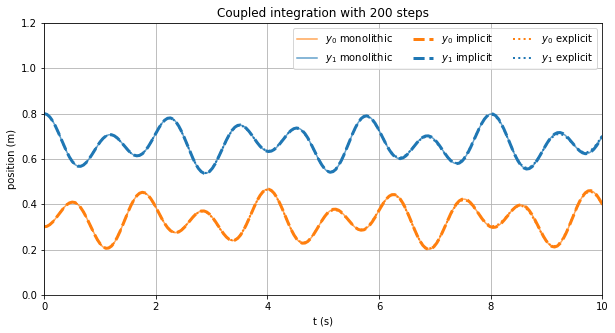

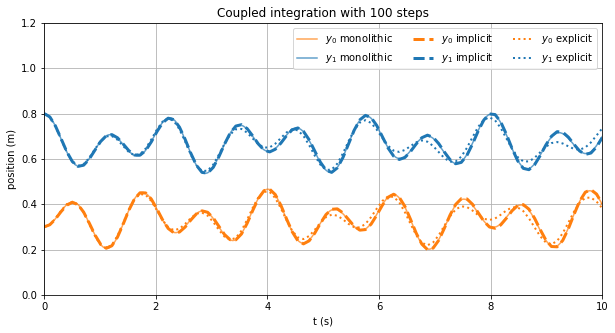

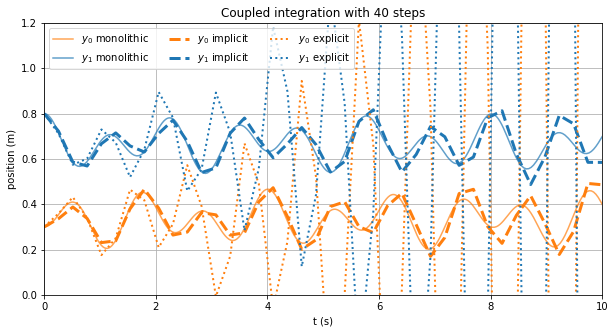

In [3]:
from rhapsopy.coupling import Orchestrator

coupler = SpringMassCoupler(k=k,m=m)
y0_global = np.array([0.3, 0, 0.8, 0])
tf = 10.
order = 3

conductor_implicit = Orchestrator(coupler=coupler, order=order)
conductor_implicit.interfaceSolver = FixedPointSolver # we use the basic fixed-point solver
conductor_implicit.waveform_tolerance = 1e-7 # error tolerance for the fixed-point solution
conductor_implicit.NITER_MAX = 1000 # maximum number of fixed-point iterations per coupling step

conductor_explicit = Orchestrator(coupler=coupler, order=order)
conductor_explicit.interfaceSolver = ExplicitSolver


for nt in [200,100,40]:
    solcoupled_implicit = conductor_implicit.basic_integration(y0=y0_global, t_vec=np.linspace(0,tf,nt))
    solcoupled_explicit = conductor_explicit.basic_integration(y0=y0_global, t_vec=np.linspace(0,tf,nt))

    plt.figure(figsize=(10,5))
    plt.plot(sol.t, sol.y[0,:], color='tab:orange', label=r'$y_0$ monolithic', alpha=0.7)
    plt.plot(sol.t, sol.y[2,:], color='tab:blue', label=r'$y_1$ monolithic', alpha=0.7)
    plt.plot(solcoupled_implicit.t, solcoupled_implicit.y[0,:],
             color='tab:orange', linestyle='--', linewidth=3, label=r'$y_0$ implicit')
    plt.plot(solcoupled_implicit.t, solcoupled_implicit.y[2,:],
             color='tab:blue', linestyle='--', linewidth=3, label=r'$y_1$ implicit')
    plt.plot(solcoupled_explicit.t, solcoupled_explicit.y[0,:],
             color='tab:orange', linestyle=':', linewidth=2, label=r'$y_0$ explicit')
    plt.plot(solcoupled_explicit.t, solcoupled_explicit.y[2,:],
             color='tab:blue', linestyle=':', linewidth=2, label=r'$y_1$ explicit')
    plt.ylim(0,1.2)
    plt.legend(ncol=3)
    plt.grid(); plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlabel('t (s)')
    plt.ylabel('position (m)')
    plt.title(f'Coupled integration with {nt} steps')

We see that the implicit result is more accurate. However the computational cost per coupling step has increased, since we have to iterate multiple times on each step.

In Tutorial 4 **"Stiff coupling"**, we will see that implicit coupling may be the only viable option for certain coupled problems where the explicit coupling suffers from instability.

Here, we simply used a fixed-point algorithm to find the converged values of the coupling variables at each step. Acceleration methods (dynamic relaxation, Newton algorithm) are available in the literature and some of them have been implemented in this library. They will be discussed in more details in an upcoming tutorial.